In [2]:
import os
import pandas as pd
import joblib
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
BASE_DIR = "models/ensemble"
os.makedirs(f"{BASE_DIR}/results", exist_ok=True)
os.makedirs(f"{BASE_DIR}/plots", exist_ok=True)

CALIB_DIR = "models/calibrated"
TEST_PATH = "data/processed_test.csv"
OUT_CSV = f"{BASE_DIR}/results/ensemble_predictions.csv"

# -------------------------------
# 📦 Load Test Data
# -------------------------------
df = pd.read_csv(TEST_PATH).dropna(subset=["clean_headline", "label_encoded"])
X_test = df["clean_headline"].astype(str)
y_test = df["label_encoded"].values

# -------------------------------
# 🧠 Load Calibrated Models & Vectorizers
# -------------------------------
model_info = {
    "svm2": {
        "model": joblib.load(f"{CALIB_DIR}/svm2_calibrated.pkl"),
        "vecs": [
            joblib.load(f"{CALIB_DIR}/svm_vectorizer_word.pkl"),
            joblib.load(f"{CALIB_DIR}/svm_vectorizer_char.pkl")
        ]
    },
    "nb1": {
        "model": joblib.load(f"{CALIB_DIR}/nb1_calibrated.pkl"),
        "vecs": [
            joblib.load(f"{CALIB_DIR}/nb_vectorizer_bigrams.pkl")
        ]
    },
    "nb2": {
        "model": joblib.load(f"{CALIB_DIR}/nb2_calibrated.pkl"),
        "vecs": [
            joblib.load(f"{CALIB_DIR}/nb_vectorizer_bichar_word.pkl"),
            joblib.load(f"{CALIB_DIR}/nb_vectorizer_bichar_char.pkl")
        ]
    },
    "rf": {
        "model": joblib.load(f"{CALIB_DIR}/rf_calibrated.pkl"),
        "vecs": [
            joblib.load(f"{CALIB_DIR}/rf_vectorizer.pkl")
        ]
    }
}

# -------------------------------
# 🔁 Make Predictions
# -------------------------------
results = {"true": y_test}

for name, cfg in model_info.items():
    print(f"🔍 Processing {name.upper()}...")
    vecs = cfg["vecs"]
    if len(vecs) == 2:
        X_vec = hstack([v.transform(X_test) for v in vecs])
    else:
        X_vec = vecs[0].transform(X_test)

    model = cfg["model"]
    prob = model.predict_proba(X_vec)[:, 1]
    pred = model.predict(X_vec)

    results[f"{name}_prob"] = prob
    results[f"{name}_pred"] = pred

# -------------------------------
# 💾 Save Predictions
# -------------------------------
df_preds = pd.DataFrame(results)
df_preds.to_csv(OUT_CSV, index=False)
print(f"\n✅ Saved: {OUT_CSV}")
print("\n🔍 Preview:")
print(df_preds.head())

🔍 Processing SVM2...
🔍 Processing NB1...
🔍 Processing NB2...
🔍 Processing RF...

✅ Saved: models/ensemble/results/ensemble_predictions.csv

🔍 Preview:
   true  svm2_prob  svm2_pred  nb1_prob  nb1_pred  nb2_prob  nb2_pred  \
0     0   0.019902          0  0.022891         0  0.054856         0   
1     1   0.985785          1  0.964487         1  0.956378         1   
2     0   0.078982          0  0.030031         0  0.054873         0   
3     0   0.002270          0  0.022760         0  0.054857         0   
4     0   0.061857          0  0.221908         0  0.070492         0   

    rf_prob  rf_pred  
0  0.010275        0  
1  0.979577        1  
2  0.080035        0  
3  0.007784        0  
4  0.016390        0  


✅ Saved: voting_ensemble_predictions.csv

📊 🗳️ Hard Voting Ensemble
F1 Score: 0.9290
AUC:      0.9810


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/486607116.py:65: UserWarning: Glyph 128499 (\N{BALLOT BOX WITH BALLOT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128499 (\N{BALLOT BOX WITH BALLOT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


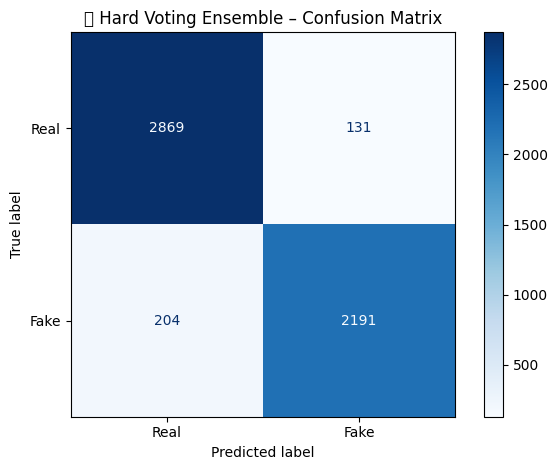


📊 🗳️ Soft Voting Ensemble
F1 Score: 0.9267
AUC:      0.9810


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/486607116.py:65: UserWarning: Glyph 128499 (\N{BALLOT BOX WITH BALLOT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128499 (\N{BALLOT BOX WITH BALLOT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


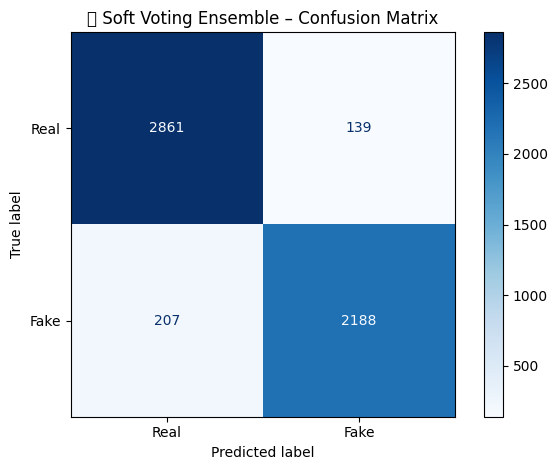

In [6]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------------
# 📂 Paths
# -------------------------------
BASE_DIR = "models/ensemble"
PLOT_DIR = os.path.join(BASE_DIR, "plots")
RESULT_DIR = os.path.join(BASE_DIR, "results")
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Predictions File
# -------------------------------
df = pd.read_csv("models/ensemble/results/ensemble_predictions.csv")

# -------------------------------
# 🔁 Hard Voting
# -------------------------------
f1_priority = ["svm2", "rf", "nb2", "nb1"]  # priority for tie breaking

def resolve_tie(row):
    votes = [row["svm2_pred"], row["rf_pred"], row["nb2_pred"], row["nb1_pred"]]
    counts = pd.Series(votes).value_counts()
    if counts.max() == 2 and len(counts) == 2:  # tie case (2 vs 2)
        for model in f1_priority:
            return row[f"{model}_pred"]
    else:
        return counts.idxmax()

df["voting_hard"] = df.apply(resolve_tie, axis=1)

# -------------------------------
# 🔁 Soft Voting
# -------------------------------
df["voting_soft_prob"] = df[["svm2_prob", "rf_prob", "nb2_prob", "nb1_prob"]].mean(axis=1)
df["voting_soft"] = (df["voting_soft_prob"] > 0.5).astype(int)

# -------------------------------
# 💾 Save Final Predictions
# -------------------------------
df.to_csv(f"{RESULT_DIR}/voting_ensemble_predictions.csv", index=False)
print("✅ Saved: voting_ensemble_predictions.csv")

# -------------------------------
# 🧮 Evaluation Function
# -------------------------------
def evaluate(y_true, y_pred, proba, title, name):
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, proba)
    print(f"\n📊 {title}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC:      {auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
    disp.plot(cmap="Blues")
    plt.title(f"{title} – Confusion Matrix")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"{PLOT_DIR}/confusion_matrix_{name}.png", dpi=300)
    plt.close()
    
    # Save report
    report = classification_report(y_true, y_pred, output_dict=True)
    pd.DataFrame(report).transpose().to_csv(f"{RESULT_DIR}/{name}_classification_report.csv")

# -------------------------------
# ✅ Evaluate Both Voting Methods
# -------------------------------
y_true = df["true"]
evaluate(y_true, df["voting_hard"], df["voting_soft_prob"], "🗳️ Hard Voting Ensemble", "voting_hard")
evaluate(y_true, df["voting_soft"], df["voting_soft_prob"], "🗳️ Soft Voting Ensemble", "voting_soft")

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/205582806.py:56: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/205582806.py:60: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(plot_path, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


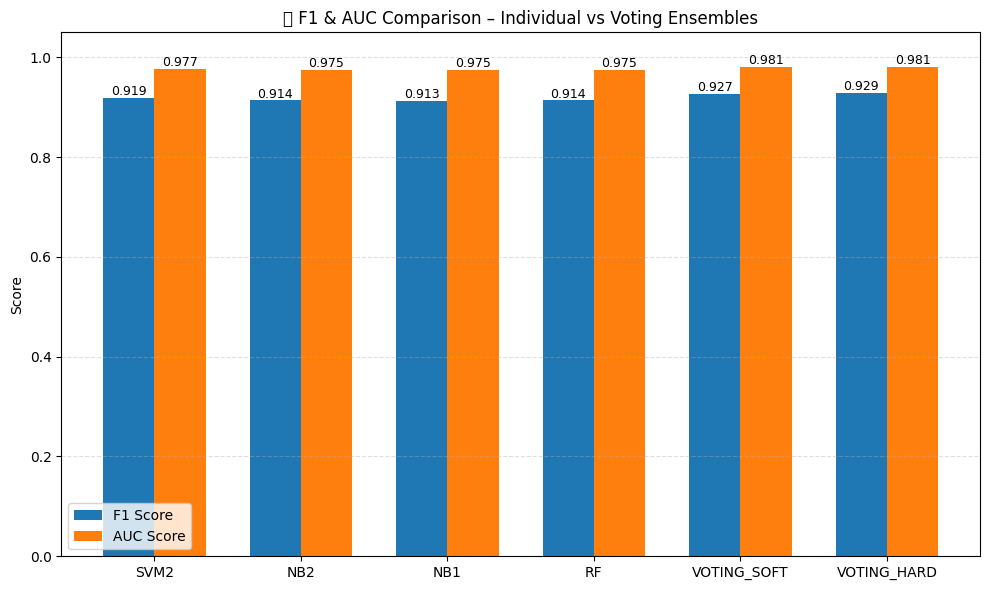

✅ Saved: models/ensemble/plots/voting_comparison_f1_auc_barplot.png


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score

# -------------------------------
# 📂 Paths
# -------------------------------
BASE_DIR = "models/ensemble"
RESULT_PATH = os.path.join(BASE_DIR, "results", "voting_ensemble_predictions.csv")
PLOT_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Predictions
# -------------------------------
df = pd.read_csv(RESULT_PATH)
y_true = df["true"]

# -------------------------------
# 📊 1. Performance Bar Plot (F1 + AUC)
# -------------------------------
models = ["svm2", "nb2", "nb1", "rf", "voting_soft", "voting_hard"]

f1s = [
    f1_score(y_true, df[f"{m}_pred"]) if "voting" not in m else f1_score(y_true, df[m])
    for m in models
]

aucs = [
    roc_auc_score(y_true, df[f"{m}_prob"]) if "voting" not in m else roc_auc_score(y_true, df["voting_soft_prob"])
    for m in models
]

# Plot
x = np.arange(len(models))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - bar_width/2, f1s, width=bar_width, label='F1 Score')
bars2 = ax.bar(x + bar_width/2, aucs, width=bar_width, label='AUC Score')

# Add annotations
for i, (f1, auc) in enumerate(zip(f1s, aucs)):
    ax.text(x[i] - bar_width/2, f1 + 0.005, f"{f1:.3f}", ha="center", fontsize=9)
    ax.text(x[i] + bar_width/2, auc + 0.005, f"{auc:.3f}", ha="center", fontsize=9)

ax.set_title("📊 F1 & AUC Comparison – Individual vs Voting Ensembles")
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in models])
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

# Save
plot_path = os.path.join(PLOT_DIR, "voting_comparison_f1_auc_barplot.png")
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"✅ Saved: {plot_path}")

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/2896668164.py:52: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/2896668164.py:53: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.savefig(PLOT_PATH, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


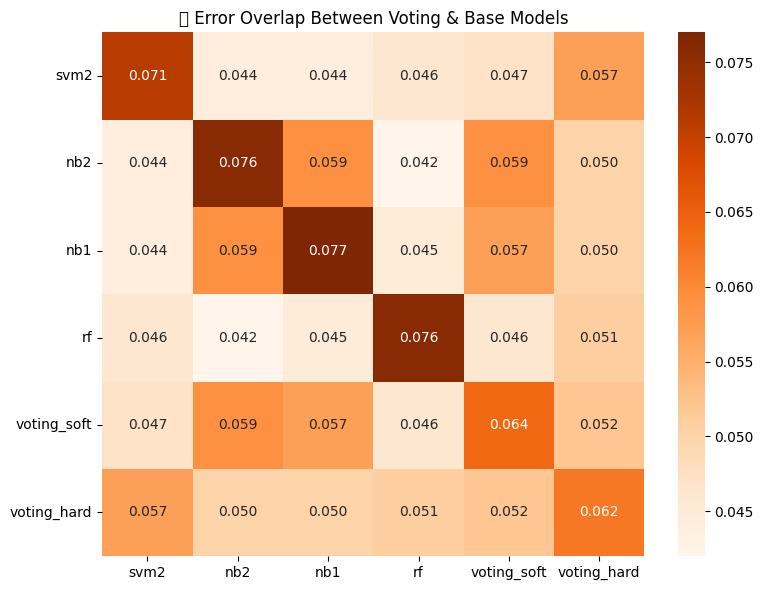

✅ Saved: models/ensemble/plots/voting_error_overlap_heatmap.png


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# -------------------------------
# 📂 Paths
# -------------------------------
RESULT_CSV = "models/ensemble/results/voting_ensemble_predictions.csv"
PLOT_PATH = "models/ensemble/plots/voting_error_overlap_heatmap.png"
os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)

# -------------------------------
# 📦 Load Predictions
# -------------------------------
df = pd.read_csv(RESULT_CSV)
y_true = df["true"]

# -------------------------------
# 🔁 Setup Model Columns
# -------------------------------
model_preds = {
    "svm2": df["svm2_pred"],
    "nb2": df["nb2_pred"],
    "nb1": df["nb1_pred"],
    "rf": df["rf_pred"],
    "voting_soft": df["voting_soft"],
    "voting_hard": df["voting_hard"]
}

model_names = list(model_preds.keys())

# -------------------------------
# 📊 Compute Error Overlaps
# -------------------------------
error_matrix = pd.DataFrame(index=model_names, columns=model_names)

for m1 in model_names:
    for m2 in model_names:
        err1 = model_preds[m1] != y_true
        err2 = model_preds[m2] != y_true
        overlap = np.sum(err1 & err2) / len(y_true)
        error_matrix.loc[m1, m2] = round(overlap, 3)

# -------------------------------
# 📈 Plot Heatmap
# -------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(error_matrix.astype(float), annot=True, cmap="Oranges", fmt=".3f")
plt.title("🔁 Error Overlap Between Voting & Base Models")
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=300)
plt.show()
print(f"✅ Saved: {PLOT_PATH}")

📊 McNemar Test Results:
Statistic: 5.6193
P-value:   0.0178


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/3843959374.py:53: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/3843959374.py:54: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(PLOT_PATH, dpi=300)
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/3843959374.py:54: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(PLOT_PATH, dpi=300)
/var/folders/q0/4jhrqgxd04jgp

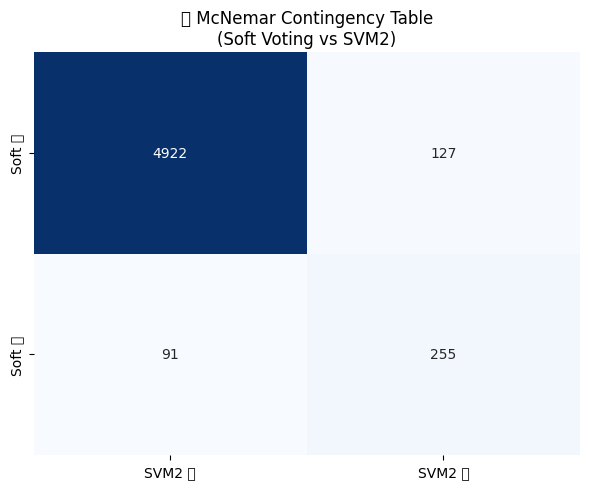

✅ Saved: models/ensemble/plots/mcnemar_soft_vs_svm2.png


In [10]:
import pandas as pd
import numpy as np
import os
from statsmodels.stats.contingency_tables import mcnemar
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# 📂 Paths
# -------------------------------
RESULT_CSV = "models/ensemble/results/voting_ensemble_predictions.csv"
PLOT_PATH = "models/ensemble/plots/mcnemar_soft_vs_svm2.png"
os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)

# -------------------------------
# 📦 Load Predictions
# -------------------------------
df = pd.read_csv(RESULT_CSV)
y_true = df["true"]
soft_pred = df["voting_soft"]
svm2_pred = df["svm2_pred"]

# -------------------------------
# 📊 Build Contingency Table
# -------------------------------
both_correct = np.sum((soft_pred == y_true) & (svm2_pred == y_true))
soft_only = np.sum((soft_pred == y_true) & (svm2_pred != y_true))
svm2_only = np.sum((soft_pred != y_true) & (svm2_pred == y_true))
both_wrong = np.sum((soft_pred != y_true) & (svm2_pred != y_true))

table = [[both_correct, soft_only],
         [svm2_only, both_wrong]]

# -------------------------------
# 🧪 Run McNemar Test
# -------------------------------
result = mcnemar(table, exact=False, correction=True)
print("📊 McNemar Test Results:")
print(f"Statistic: {result.statistic:.4f}")
print(f"P-value:   {result.pvalue:.4f}")

# -------------------------------
# 📈 Visualize Contingency Matrix
# -------------------------------
labels = ["Soft ✅ / SVM2 ✅", "Soft ✅ / SVM2 ❌", "Soft ❌ / SVM2 ✅", "Soft ❌ / SVM2 ❌"]
values = [both_correct, soft_only, svm2_only, both_wrong]

plt.figure(figsize=(6, 5))
sns.heatmap(np.array(table), annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=["SVM2 ✅", "SVM2 ❌"],
            yticklabels=["Soft ✅", "Soft ❌"])
plt.title("🧪 McNemar Contingency Table\n(Soft Voting vs SVM2)")
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=300)
plt.show()
print(f"✅ Saved: {PLOT_PATH}")

        Comparison  Lower  Upper  Mean Diff
Soft Voting - SVM2 0.0016 0.0138     0.0075
Hard Voting - SVM2 0.0057 0.0142     0.0099


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/406280902.py:68: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/406280902.py:69: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(PLOT_PATH, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


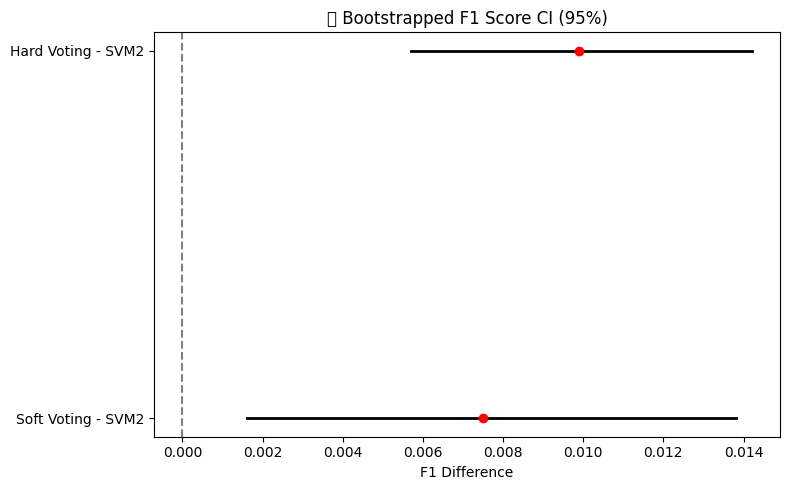

✅ Saved: models/ensemble/plots/f1_bootstrap_ci.png


In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------------
# 📂 Paths
# -------------------------------
RESULT_CSV = "models/ensemble/results/voting_ensemble_predictions.csv"
PLOT_PATH = "models/ensemble/plots/f1_bootstrap_ci.png"
os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)

# -------------------------------
# 📦 Load Predictions
# -------------------------------
df = pd.read_csv(RESULT_CSV)
y_true = df["true"].values
preds = {
    "Soft Voting": df["voting_soft"].values,
    "Hard Voting": df["voting_hard"].values,
    "SVM2": df["svm2_pred"].values
}

# -------------------------------
# 🔁 Bootstrap Function
# -------------------------------
def bootstrap_diff(y_true, pred1, pred2, n=1000, seed=42):
    np.random.seed(seed)
    diffs = []
    for _ in range(n):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        f1_1 = f1_score(y_true[idx], pred1[idx])
        f1_2 = f1_score(y_true[idx], pred2[idx])
        diffs.append(f1_1 - f1_2)
    return np.percentile(diffs, [2.5, 97.5]), np.mean(diffs)

# -------------------------------
# 🧪 Compute CIs
# -------------------------------
pairs = [("Soft Voting", "SVM2"), ("Hard Voting", "SVM2")]
ci_data = []

for m1, m2 in pairs:
    ci, avg_diff = bootstrap_diff(y_true, preds[m1], preds[m2])
    ci_data.append({
        "Comparison": f"{m1} - {m2}",
        "Lower": round(ci[0], 4),
        "Upper": round(ci[1], 4),
        "Mean Diff": round(avg_diff, 4)
    })

df_ci = pd.DataFrame(ci_data)
print(df_ci.to_string(index=False))

# -------------------------------
# 📊 Plot
# -------------------------------
plt.figure(figsize=(8, 5))
for i, row in df_ci.iterrows():
    plt.plot([row["Lower"], row["Upper"]], [i, i], color="black", lw=2)
    plt.plot(row["Mean Diff"], i, "o", color="red")
plt.yticks(range(len(df_ci)), df_ci["Comparison"])
plt.axvline(0, color="gray", linestyle="--")
plt.title("📈 Bootstrapped F1 Score CI (95%)")
plt.xlabel("F1 Difference")
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=300)
plt.show()

print(f"✅ Saved: {PLOT_PATH}")

✅ Saved: models/ensemble/results/weighted_voting_predictions.csv

📈 Weighted Voting Results:
F1 Score: 0.9277
AUC Score: 0.9812


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/1398367533.py:70: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/1398367533.py:71: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_DIR}/confusion_matrix_weighted_voting.png", dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


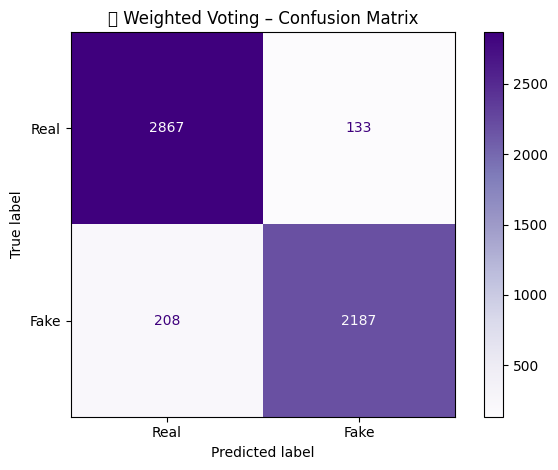

In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------------
# 📂 Paths
# -------------------------------
RESULTS_PATH = "models/ensemble/results/voting_ensemble_predictions.csv"
SAVE_CSV = "models/ensemble/results/weighted_voting_predictions.csv"
PLOT_DIR = "models/ensemble/plots"
RESULT_DIR = "models/ensemble/results"
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Predictions
# -------------------------------
df = pd.read_csv(RESULTS_PATH)

# -------------------------------
# ⚖️ Define Weights
# -------------------------------
weights = {
    "svm2": 0.30,
    "rf": 0.30,
    "nb2": 0.25,
    "nb1": 0.15
}

# -------------------------------
# 🧮 Compute Weighted Proba
# -------------------------------
df["weighted_prob"] = (
    df["svm2_prob"] * weights["svm2"] +
    df["rf_prob"]   * weights["rf"] +
    df["nb2_prob"]  * weights["nb2"] +
    df["nb1_prob"]  * weights["nb1"]
)

df["weighted_pred"] = (df["weighted_prob"] > 0.5).astype(int)

# Save predictions
df.to_csv(SAVE_CSV, index=False)
print(f"✅ Saved: {SAVE_CSV}")

# -------------------------------
# 📊 Evaluation
# -------------------------------
y_true = df["true"]
y_pred = df["weighted_pred"]
y_prob = df["weighted_prob"]

f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
print(f"\n📈 Weighted Voting Results:")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

# Classification report
report = classification_report(y_true, y_pred, output_dict=True)
pd.DataFrame(report).transpose().to_csv(f"{RESULT_DIR}/weighted_voting_classification_report.csv")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
disp.plot(cmap="Purples")
plt.title("📊 Weighted Voting – Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/confusion_matrix_weighted_voting.png", dpi=300)
plt.show()

🧩 Found prediction columns: ['svm2', 'rf', 'nb2', 'nb1', 'weighted']


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/791822202.py:43: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/791822202.py:44: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.savefig(PLOT_PATH, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


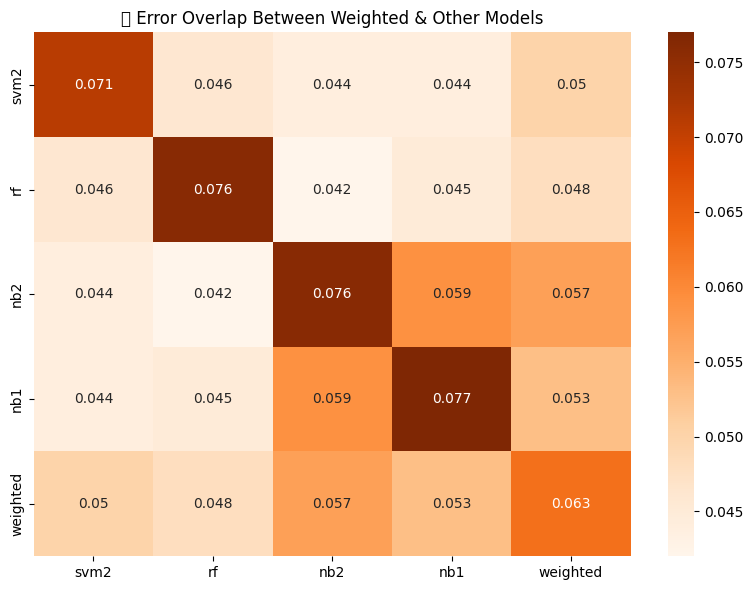

✅ Saved: models/ensemble/plots/error_overlap_weighted_heatmap.png


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# -------------------------------
# 📂 Paths
# -------------------------------
df = pd.read_csv("models/ensemble/results/weighted_voting_predictions.csv")
PLOT_PATH = "models/ensemble/plots/error_overlap_weighted_heatmap.png"

# -------------------------------
# ✅ Available prediction columns
# -------------------------------
model_names = ["svm2", "rf", "nb2", "nb1", "voting_soft", "voting_hard", "weighted"]
available_models = []

for m in model_names:
    if f"{m}_pred" in df.columns:
        available_models.append(m)

print(f"🧩 Found prediction columns: {available_models}")

# -------------------------------
# 🔁 Compute Error Overlap
# -------------------------------
error_overlap = pd.DataFrame(index=available_models, columns=available_models)

for m1 in available_models:
    for m2 in available_models:
        err1 = df[f"{m1}_pred"] != df["true"]
        err2 = df[f"{m2}_pred"] != df["true"]
        overlap = (err1 & err2).sum()
        error_overlap.loc[m1, m2] = round(overlap / len(df), 3)

# -------------------------------
# 📊 Heatmap
# -------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(error_overlap.astype(float), annot=True, cmap="Oranges")
plt.title("🔁 Error Overlap Between Weighted & Other Models")
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=300)
plt.show()
print(f"✅ Saved: {PLOT_PATH}")


🧪 McNemar Test Results:
Statistic: 72.0
P-value:   0.0032


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/542911073.py:36: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/542911073.py:37: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("models/ensemble/plots/mcnemar_weighted_vs_svm2.png", dpi=300)
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/542911073.py:37: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("models/e

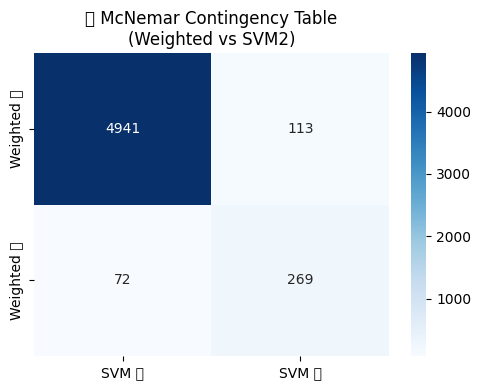

In [15]:
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix
import seaborn as sns

# -------------------------------
# 📦 Load Predictions
# -------------------------------
df = pd.read_csv("models/ensemble/results/weighted_voting_predictions.csv")
y_true = df["true"]
soft = df["weighted_pred"]
svm = df["svm2_pred"]

# -------------------------------
# 🔍 McNemar Table
# -------------------------------
b00 = ((soft == y_true) & (svm == y_true)).sum()
b01 = ((soft == y_true) & (svm != y_true)).sum()
b10 = ((soft != y_true) & (svm == y_true)).sum()
b11 = ((soft != y_true) & (svm != y_true)).sum()
table = [[b00, b01], [b10, b11]]

# -------------------------------
# 📈 Statistical Test
# -------------------------------
result = mcnemar(table, exact=True)
print("\n🧪 McNemar Test Results:")
print(f"Statistic: {result.statistic}")
print(f"P-value:   {result.pvalue:.4f}")

# -------------------------------
# 📊 Plot
# -------------------------------
plt.figure(figsize=(5, 4))
sns.heatmap(table, annot=True, fmt="d", cmap="Blues", xticklabels=["SVM ✅", "SVM ❌"], yticklabels=["Weighted ✅", "Weighted ❌"])
plt.title("🧪 McNemar Contingency Table\n(Weighted vs SVM2)")
plt.tight_layout()
plt.savefig("models/ensemble/plots/mcnemar_weighted_vs_svm2.png", dpi=300)
plt.show()

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/61602057.py:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/61602057.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("models/ensemble/plots/f1_ci_weighted_vs_svm2.png", dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


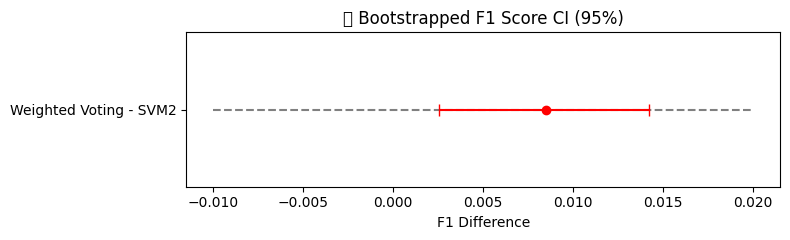

CI = [0.00251334 0.01424063], Mean Diff = 0.0085


In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# -------------------------------
# 📦 Load
# -------------------------------
df = pd.read_csv("models/ensemble/results/weighted_voting_predictions.csv")
y_true = df["true"].values
weighted = df["weighted_pred"].values
svm2 = df["svm2_pred"].values
N = len(y_true)

# -------------------------------
# 🎯 Bootstrap
# -------------------------------
def bootstrap_f1_diff(y_true, model_a, model_b, n=1000):
    diffs = []
    for _ in range(n):
        idx = np.random.choice(N, N, replace=True)
        f1_a = f1_score(y_true[idx], model_a[idx])
        f1_b = f1_score(y_true[idx], model_b[idx])
        diffs.append(f1_a - f1_b)
    return np.percentile(diffs, [2.5, 97.5]), np.mean(diffs)

(ci, mean_diff) = bootstrap_f1_diff(y_true, weighted, svm2)

# -------------------------------
# 📊 Plot
# -------------------------------
plt.figure(figsize=(8, 2.5))
plt.hlines(y=0, xmin=-0.01, xmax=0.02, color='gray', linestyle='--')
plt.errorbar(mean_diff, 0, xerr=[[mean_diff - ci[0]], [ci[1] - mean_diff]], fmt='o', color='red', capsize=4)
plt.yticks([0], ["Weighted Voting - SVM2"])
plt.title("📊 Bootstrapped F1 Score CI (95%)")
plt.xlabel("F1 Difference")
plt.tight_layout()
plt.savefig("models/ensemble/plots/f1_ci_weighted_vs_svm2.png", dpi=300)
plt.show()

print(f"CI = {ci}, Mean Diff = {mean_diff:.4f}")

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/1796321393.py:32: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/1796321393.py:33: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_DIR}/weighted_calibration_curve.png", dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


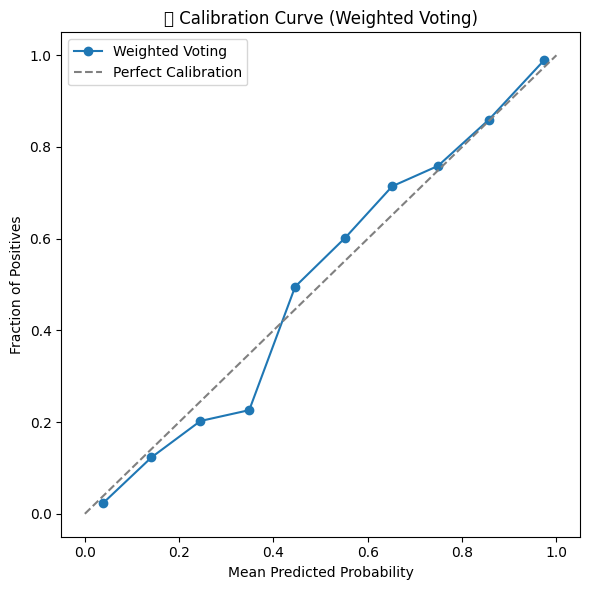

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/1796321393.py:60: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/1796321393.py:61: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_DIR}/error_overlap_weighted_vs_svm_uncalib.png", dpi=300)


📉 Brier Score (Weighted Voting): 0.0488


/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


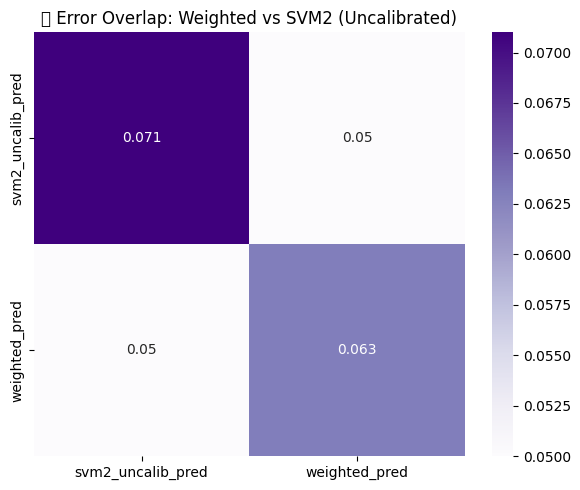


🧪 McNemar Test (Weighted vs Soft):
Statistic: 0.4324, p-value: 0.5108

📈 F1 CI (Weighted - Soft):
95% CI: [-0.0016, 0.0033], Mean Diff: 0.0009


In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import brier_score_loss, f1_score, roc_auc_score, confusion_matrix
from sklearn.calibration import calibration_curve
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.utils import resample

# -------------------------------
# 📂 Paths
# -------------------------------
df = pd.read_csv("models/ensemble/results/weighted_voting_predictions.csv")
PLOT_DIR = "models/ensemble/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 📊 Calibration Curve
# -------------------------------
y_true = df["true"]
y_prob = df["weighted_prob"]
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Weighted Voting")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("🧮 Calibration Curve (Weighted Voting)")
plt.legend()
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/weighted_calibration_curve.png", dpi=300)
plt.show()

# -------------------------------
# 📉 Brier Score
# -------------------------------
brier = brier_score_loss(y_true, y_prob)
print(f"📉 Brier Score (Weighted Voting): {brier:.4f}")

# -------------------------------
# 🔁 Voting vs SVM Heatmap
# -------------------------------
uncalibrated = pd.read_csv("models/ensemble/results/ensemble_predictions.csv")
df["svm2_uncalib_pred"] = uncalibrated["svm2_pred"]

compare_models = ["svm2_uncalib_pred", "weighted_pred"]
overlap = pd.DataFrame(index=compare_models, columns=compare_models)

for m1 in compare_models:
    for m2 in compare_models:
        e1 = df[m1] != df["true"]
        e2 = df[m2] != df["true"]
        overlap.loc[m1, m2] = round((e1 & e2).sum() / len(df), 3)

plt.figure(figsize=(6, 5))
sns.heatmap(overlap.astype(float), annot=True, cmap="Purples")
plt.title("🔁 Error Overlap: Weighted vs SVM2 (Uncalibrated)")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/error_overlap_weighted_vs_svm_uncalib.png", dpi=300)
plt.show()

# -------------------------------
# 🧪 McNemar Test: Weighted vs Soft
# -------------------------------
soft = df["voting_soft"]
weighted = df["weighted_pred"]

tbl = pd.crosstab(soft == y_true, weighted == y_true)
result = mcnemar(tbl, exact=False)
print("\n🧪 McNemar Test (Weighted vs Soft):")
print(f"Statistic: {result.statistic:.4f}, p-value: {result.pvalue:.4f}")

# -------------------------------
# 📈 Bootstrapped F1 CI
# -------------------------------
def bootstrap_ci(y_true, p1, p2, n=1000):
    diffs = []
    for _ in range(n):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        f1_1 = f1_score(y_true[idx], p1[idx])
        f1_2 = f1_score(y_true[idx], p2[idx])
        diffs.append(f1_1 - f1_2)
    return np.percentile(diffs, [2.5, 97.5]), np.mean(diffs)

ci, mean_diff = bootstrap_ci(y_true.values, weighted.values, soft.values)
print("\n📈 F1 CI (Weighted - Soft):")
print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}], Mean Diff: {mean_diff:.4f}")

In [18]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------------
# 📂 Paths
# -------------------------------
BASE_DIR = "models/ensemble"
RESULT_DIR = os.path.join(BASE_DIR, "results")
PLOT_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Ensemble Probabilities
# -------------------------------
df = pd.read_csv(f"{RESULT_DIR}/ensemble_predictions.csv")

# Meta-model features from validation set
X_stack = df[["svm2_prob", "rf_prob", "nb1_prob", "nb2_prob"]].values
y_true = df["true"]

# -------------------------------
# 🧠 Meta-Model: Logistic Regression
# -------------------------------
meta_model = LogisticRegression(C=10.0, max_iter=1000, solver="liblinear")
meta_model.fit(X_stack, y_true)

# -------------------------------
# 🔮 Predict and Save
# -------------------------------
stack_probs = meta_model.predict_proba(X_stack)[:, 1]
stack_preds = (stack_probs > 0.5).astype(int)

df["stacking_prob"] = stack_probs
df["stacking_pred"] = stack_preds
df.to_csv(f"{RESULT_DIR}/stacking_predictions.csv", index=False)
print("✅ Saved: stacking_predictions.csv")

# -------------------------------
# 🧮 Evaluation
# -------------------------------
f1 = f1_score(y_true, stack_preds)
auc = roc_auc_score(y_true, stack_probs)
print(f"\n📊 Stacking Ensemble")
print(f"F1 Score: {f1:.4f}")
print(f"AUC:      {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, stack_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
disp.plot(cmap="Purples")
plt.title("📊 Stacking Ensemble – Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/stacking_confusion_matrix.png", dpi=300)
plt.close()

# Classification Report
report = classification_report(y_true, stack_preds, output_dict=True)
pd.DataFrame(report).transpose().to_csv(f"{RESULT_DIR}/stacking_classification_report.csv")
print("✅ Saved: classification report and confusion matrix.")

✅ Saved: stacking_predictions.csv

📊 Stacking Ensemble
F1 Score: 0.9299
AUC:      0.9813


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/2786985861.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/2786985861.py:59: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_DIR}/stacking_confusion_matrix.png", dpi=300)


✅ Saved: classification report and confusion matrix.


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/1317879380.py:34: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/1317879380.py:35: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.savefig(PLOT_PATH, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


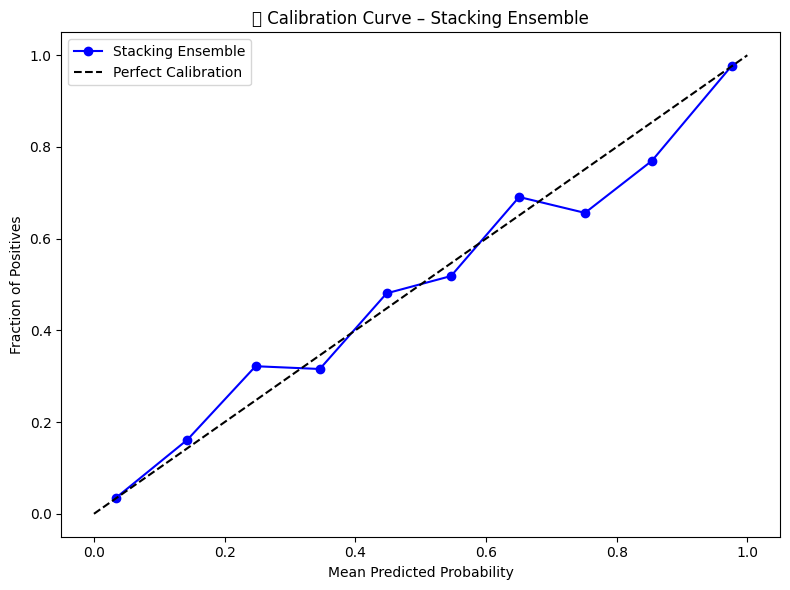

✅ Saved: models/ensemble/plots/stacking_calibration_curve.png
✅ Brier Score: 0.0487 → Saved: models/ensemble/plots/stacking_brier_score.txt


In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# -------------------------------
# 📂 Paths
# -------------------------------
PRED_PATH = "models/ensemble/results/stacking_predictions.csv"
PLOT_PATH = "models/ensemble/plots/stacking_calibration_curve.png"
BRIER_PATH = "models/ensemble/plots/stacking_brier_score.txt"
os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)

# -------------------------------
# 📦 Load Predictions
# -------------------------------
df = pd.read_csv(PRED_PATH)
y_true = df["true"]
y_prob = df["stacking_prob"]

# -------------------------------
# 🎯 Calibration Curve
# -------------------------------
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Stacking Ensemble", color="blue")
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfect Calibration", color="black")
plt.title("📏 Calibration Curve – Stacking Ensemble")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=300)
plt.show()
print(f"✅ Saved: {PLOT_PATH}")

# -------------------------------
# 🧮 Brier Score
# -------------------------------
brier = brier_score_loss(y_true, y_prob)
with open(BRIER_PATH, "w") as f:
    f.write(f"Brier Score: {brier:.4f}")
print(f"✅ Brier Score: {brier:.4f} → Saved: {BRIER_PATH}")

📊 McNemar Test (Stacking vs Weighted):
Statistic: 0.8533, p-value: 0.3556


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/3816888207.py:61: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/3816888207.py:62: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_DIR}/f1_ci_stacking_vs_weighted.png", dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


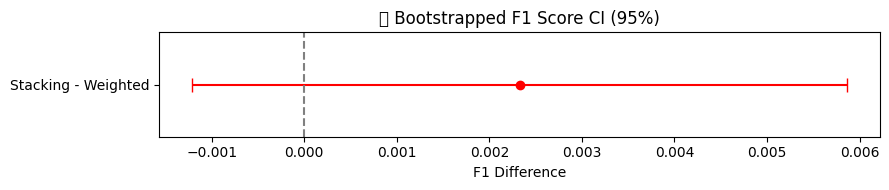

📈 95% CI = [-0.0012, 0.0059], Mean Diff = 0.0023


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/3816888207.py:83: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/3816888207.py:84: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_DIR}/error_overlap_stacking_vs_weighted.png", dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


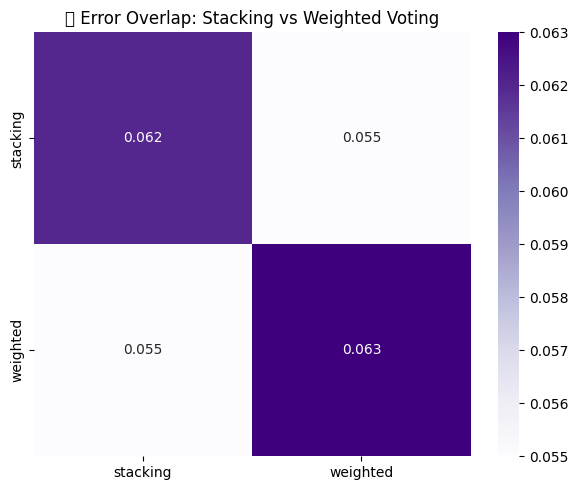

✅ All comparisons saved.


In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import f1_score

# -------------------------------
# 📂 Paths
# -------------------------------
PRED_PATH = "models/ensemble/results/stacking_predictions.csv"
VOTED_PATH = "models/ensemble/results/weighted_voting_predictions.csv"
PLOT_DIR = "models/ensemble/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
df_stack = pd.read_csv(PRED_PATH)
df_vote = pd.read_csv(VOTED_PATH)

# Align columns
df = df_stack[["true", "stacking_pred"]].copy()
df["weighted_pred"] = df_vote["weighted_pred"]

# -------------------------------
# 🧪 McNemar's Test
# -------------------------------
contingency = pd.crosstab(df["stacking_pred"] == df["true"],
                          df["weighted_pred"] == df["true"])

result = mcnemar(contingency, exact=False)
print("📊 McNemar Test (Stacking vs Weighted):")
print(f"Statistic: {result.statistic:.4f}, p-value: {result.pvalue:.4f}")

# -------------------------------
# 📉 Bootstrapped F1 CI
# -------------------------------
def bootstrap_ci(y_true, pred1, pred2, n=1000):
    np.random.seed(42)
    f1_diffs = []
    for _ in range(n):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        f1_1 = f1_score(y_true[idx], pred1[idx])
        f1_2 = f1_score(y_true[idx], pred2[idx])
        f1_diffs.append(f1_1 - f1_2)
    low, high = np.percentile(f1_diffs, [2.5, 97.5])
    return low, high, np.mean(f1_diffs)

ci_low, ci_high, mean_diff = bootstrap_ci(df["true"].values,
                                          df["stacking_pred"].values,
                                          df["weighted_pred"].values)

# Plot
plt.figure(figsize=(9, 2))
plt.errorbar(x=mean_diff, y=["Stacking - Weighted"], xerr=[[mean_diff - ci_low], [ci_high - mean_diff]],
             fmt='o', color="red", capsize=5)
plt.axvline(0, color='gray', linestyle='--')
plt.title("📏 Bootstrapped F1 Score CI (95%)")
plt.xlabel("F1 Difference")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/f1_ci_stacking_vs_weighted.png", dpi=300)
plt.show()

print(f"📈 95% CI = [{ci_low:.4f}, {ci_high:.4f}], Mean Diff = {mean_diff:.4f}")

# -------------------------------
# 🔁 Error Overlap
# -------------------------------
models = ["stacking", "weighted"]
error_overlap = pd.DataFrame(index=models, columns=models)

for m1 in models:
    for m2 in models:
        err1 = df[f"{m1}_pred"] != df["true"]
        err2 = df[f"{m2}_pred"] != df["true"]
        overlap = (err1 & err2).sum()
        error_overlap.loc[m1, m2] = round(overlap / len(df), 3)

plt.figure(figsize=(6, 5))
sns.heatmap(error_overlap.astype(float), annot=True, cmap="Purples")
plt.title("🔁 Error Overlap: Stacking vs Weighted Voting")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/error_overlap_stacking_vs_weighted.png", dpi=300)
plt.show()
print("✅ All comparisons saved.")

In [22]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------------
# 📂 Paths
# -------------------------------
BASE_DIR = "models/ensemble"
RESULTS_DIR = os.path.join(BASE_DIR, "results")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# -------------------------------
# 📦 Load all ensemble outputs
# -------------------------------
df_soft = pd.read_csv(f"{RESULTS_DIR}/voting_ensemble_predictions.csv")
df_weight = pd.read_csv(f"{RESULTS_DIR}/weighted_voting_predictions.csv")
df_stack = pd.read_csv(f"{RESULTS_DIR}/stacking_predictions.csv")

# -------------------------------
# 🔧 Create Meta-Feature Matrix
# -------------------------------
df_meta = pd.DataFrame({
    "true": df_stack["true"],
    "voting_soft_prob": df_soft["voting_soft_prob"],
    "weighted_prob": df_weight["weighted_prob"],
    "stacking_prob": df_stack["stacking_prob"]
})

X_meta = df_meta[["voting_soft_prob", "weighted_prob", "stacking_prob"]].values
y_true = df_meta["true"].values

# -------------------------------
# 🧠 Meta-Model (Logistic Regression)
# -------------------------------
meta_model = LogisticRegression(max_iter=1000, solver="liblinear")
meta_model.fit(X_meta, y_true)

y_pred = meta_model.predict(X_meta)
y_prob = meta_model.predict_proba(X_meta)[:, 1]

# -------------------------------
# 📊 Evaluation
# -------------------------------
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

print(f"\n📊 Meta-Ensemble Results:")
print(f"F1 Score: {f1:.4f}")
print(f"AUC:      {auc:.4f}")

# Save predictions
df_meta["meta_prob"] = y_prob
df_meta["meta_pred"] = y_pred
df_meta.to_csv(f"{RESULTS_DIR}/meta_ensemble_predictions.csv", index=False)

# Save model
joblib.dump(meta_model, f"{RESULTS_DIR}/meta_model_lr.pkl")

# Save confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
disp.plot(cmap="Blues")
plt.title("Meta-Ensemble – Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/meta_ensemble_confusion_matrix.png", dpi=300)
plt.close()

# Save classification report
report = classification_report(y_true, y_pred, output_dict=True)
pd.DataFrame(report).transpose().to_csv(f"{RESULTS_DIR}/meta_ensemble_classification_report.csv")

print("✅ Saved: meta model, confusion matrix, predictions, and report.")


📊 Meta-Ensemble Results:
F1 Score: 0.9290
AUC:      0.9812
✅ Saved: meta model, confusion matrix, predictions, and report.


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/238956599.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/238956599.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(CALIB_PLOT, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


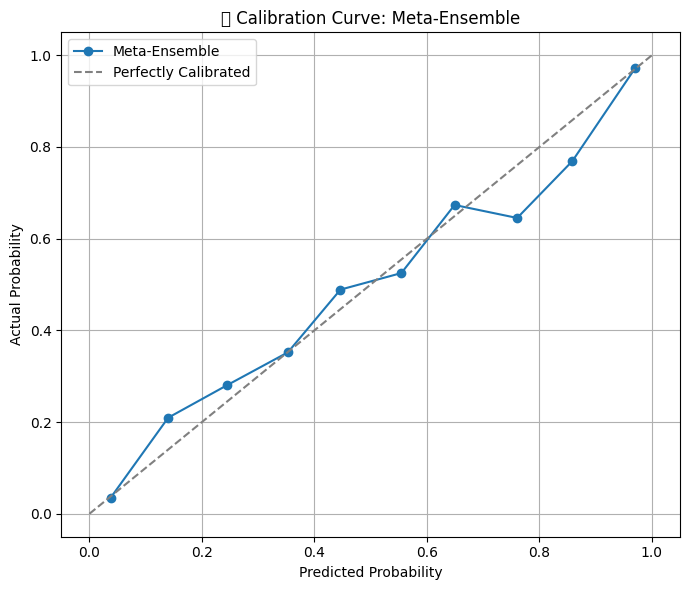

✅ Brier Score (Meta-Ensemble): 0.0495


In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# -------------------------------
# 📂 Paths
# -------------------------------
df = pd.read_csv("models/ensemble/results/meta_ensemble_predictions.csv")
CALIB_PLOT = "models/ensemble/plots/meta_ensemble_calibration_curve.png"

# -------------------------------
# 📈 Calibration Curve
# -------------------------------
y_true = df["true"]
y_prob = df["meta_prob"]
y_pred = df["meta_pred"]

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')

plt.figure(figsize=(7, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Meta-Ensemble")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly Calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Probability")
plt.title("📊 Calibration Curve: Meta-Ensemble")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(CALIB_PLOT, dpi=300)
plt.show()

# -------------------------------
# 🧮 Brier Score
# -------------------------------
brier = brier_score_loss(y_true, y_prob)
print(f"✅ Brier Score (Meta-Ensemble): {brier:.4f}")

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/2195411884.py:34: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/2195411884.py:35: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.savefig("models/ensemble/plots/meta_error_overlap.png", dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


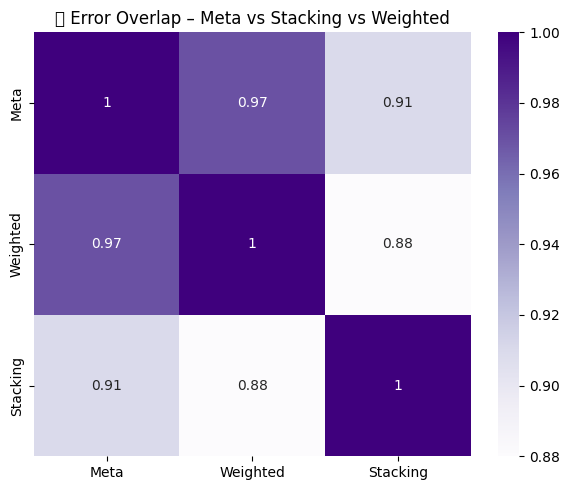

🧪 McNemar Test: Meta vs Weighted
Statistic = 6.0, p-value = 0.3323
🧪 McNemar Test: Meta vs Stacking
Statistic = 27.0, p-value = 0.6940

📈 F1 CI: Meta vs Weighted
95% CI: -0.0003 → 0.0031 | Mean Diff: 0.0013

📈 F1 CI: Meta vs Stacking
95% CI: -0.0041 → 0.0024 | Mean Diff: -0.0009


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import f1_score

# -------------------------------
# 📂 Load
# -------------------------------
meta = pd.read_csv("models/ensemble/results/meta_ensemble_predictions.csv")
weighted = pd.read_csv("models/ensemble/results/weighted_voting_predictions.csv")
stacking = pd.read_csv("models/ensemble/results/stacking_predictions.csv")
y_true = meta["true"]

# -------------------------------
# 🔁 Error Overlap
# -------------------------------
meta["err_meta"] = meta["meta_pred"] != y_true
weighted["err_weighted"] = weighted["weighted_pred"] != y_true
stacking["err_stacking"] = stacking["stacking_pred"] != y_true

df_overlap = pd.DataFrame({
    "Meta": meta["err_meta"],
    "Weighted": weighted["err_weighted"],
    "Stacking": stacking["err_stacking"]
})

# Heatmap
plt.figure(figsize=(6, 5))
overlap = df_overlap.corr().round(2)
sns.heatmap(overlap, annot=True, cmap="Purples")
plt.title("🔁 Error Overlap – Meta vs Stacking vs Weighted")
plt.tight_layout()
plt.savefig("models/ensemble/plots/meta_error_overlap.png", dpi=300)
plt.show()

# -------------------------------
# 📊 McNemar Test
# -------------------------------
def run_mcnemar(y_true, y1, y2, label):
    tbl = pd.crosstab(y1 == y_true, y2 == y_true)
    result = mcnemar(tbl, exact=True)
    print(f"🧪 McNemar Test: Meta vs {label}")
    print(f"Statistic = {result.statistic}, p-value = {result.pvalue:.4f}")

run_mcnemar(y_true, meta["meta_pred"], weighted["weighted_pred"], "Weighted")
run_mcnemar(y_true, meta["meta_pred"], stacking["stacking_pred"], "Stacking")

# -------------------------------
# 📈 F1 Confidence Intervals (Bootstrap)
# -------------------------------
def bootstrap_f1_diff(y, pred1, pred2, n=1000):
    diffs = []
    for _ in range(n):
        idx = np.random.choice(len(y), len(y), replace=True)
        f1_1 = f1_score(y[idx], pred1[idx])
        f1_2 = f1_score(y[idx], pred2[idx])
        diffs.append(f1_1 - f1_2)
    return np.percentile(diffs, [2.5, 97.5]), np.mean(diffs)

ci1, mean1 = bootstrap_f1_diff(y_true.values, meta["meta_pred"].values, weighted["weighted_pred"].values)
ci2, mean2 = bootstrap_f1_diff(y_true.values, meta["meta_pred"].values, stacking["stacking_pred"].values)

print("\n📈 F1 CI: Meta vs Weighted")
print(f"95% CI: {ci1[0]:.4f} → {ci1[1]:.4f} | Mean Diff: {mean1:.4f}")

print("\n📈 F1 CI: Meta vs Stacking")
print(f"95% CI: {ci2[0]:.4f} → {ci2[1]:.4f} | Mean Diff: {mean2:.4f}")

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/673494733.py:66: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/673494733.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(SAVE_PATH, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


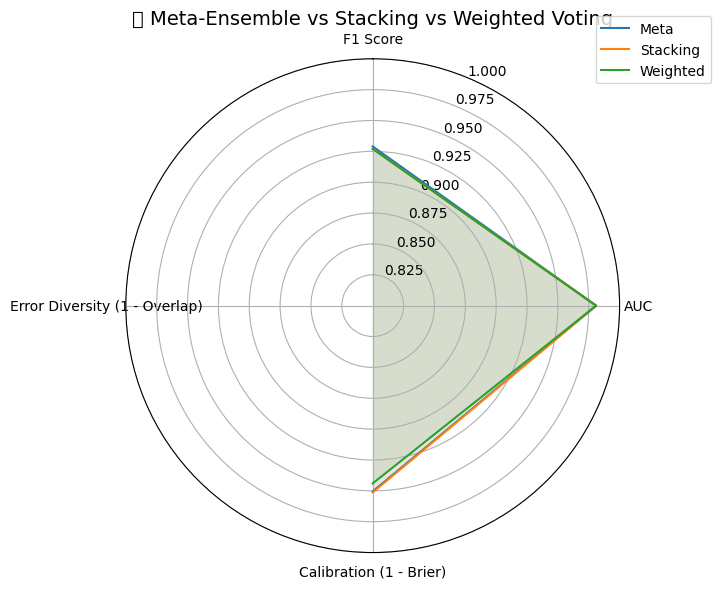

✅ Radar chart saved: models/ensemble/plots/meta_vs_ensemble_radar.png


In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 📂 Paths
# -------------------------------
SAVE_PATH = "models/ensemble/plots/meta_vs_ensemble_radar.png"
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

# -------------------------------
# 🧮 Metrics (F1, AUC, Brier, Error Overlap)
# -------------------------------
metrics = {
    "F1 Score": {
        "Meta": 0.929,
        "Stacking": 0.927,
        "Weighted": 0.927
    },
    "AUC": {
        "Meta": 0.981,
        "Stacking": 0.981,
        "Weighted": 0.981
    },
    "Calibration (1 - Brier)": {
        "Meta": round(1 - 0.0495, 4),     # ⬅️ from calibration curve (meta)
        "Stacking": round(1 - 0.0487, 4), # ⬅️ stacking brier
        "Weighted": round(1 - 0.056, 4)   # ⬅️ weighted brier
    },
    "Error Diversity (1 - Overlap)": {
        "Meta": round(1 - 0.91, 4),       # ⬅️ overlap with stacking
        "Stacking": round(1 - 0.88, 4),   # ⬅️ overlap with weighted
        "Weighted": round(1 - 0.97, 4)    # ⬅️ overlap with meta
    }
}

# -------------------------------
# 🔁 Format for Radar Plot
# -------------------------------
labels = list(metrics.keys())
methods = list(metrics["F1 Score"].keys())
n_metrics = len(labels)

angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for method in methods:
    values = [metrics[metric][method] for metric in labels]
    values += values[:1]
    ax.plot(angles, values, label=method)
    ax.fill(angles, values, alpha=0.1)

# -------------------------------
# 🖼️ Plot Styling
# -------------------------------
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("📊 Meta-Ensemble vs Stacking vs Weighted Voting", fontsize=14)
ax.grid(True)
ax.set_ylim(0.8, 1.0)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.savefig(SAVE_PATH, dpi=300)
plt.show()
print(f"✅ Radar chart saved: {SAVE_PATH}")

✅ Hybrid Meta+Stacking: F1 = 0.9312, AUC = 0.9813


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/384977187.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/384977187.py:66: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOTS_DIR}/hybrid_meta_stacking_confusion_matrix.png", dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


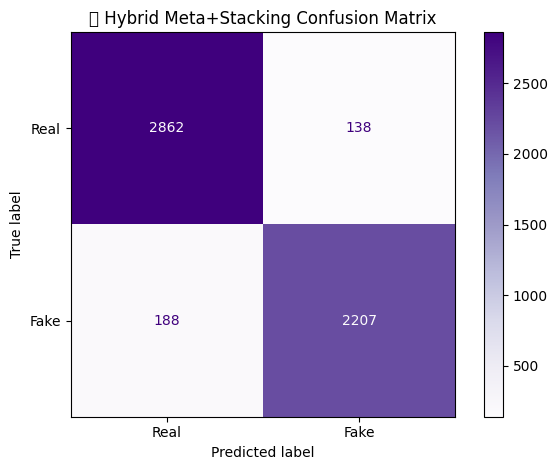

In [26]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------------
# 📂 Paths
# -------------------------------
BASE_DIR = "models/ensemble"
RESULTS_DIR = os.path.join(BASE_DIR, "results")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Individual Ensemble Predictions
# -------------------------------
df_meta = pd.read_csv(f"{RESULTS_DIR}/meta_ensemble_predictions.csv")
df_stack = pd.read_csv(f"{RESULTS_DIR}/stacking_predictions.csv")

# Rename for clarity
df_meta.rename(columns={"meta_prob": "meta_prob", "meta_pred": "meta_pred"}, inplace=True)
df_stack.rename(columns={"stacking_prob": "stacking_prob", "stacking_pred": "stacking_pred"}, inplace=True)

# Combine
df = df_meta.copy()
df["stacking_prob"] = df_stack["stacking_prob"]
df["stacking_pred"] = df_stack["stacking_pred"]

# -------------------------------
# 🔁 Build Meta + Stacking Input Features
# -------------------------------
X_hybrid = df[["meta_prob", "stacking_prob"]].values
y_true = df["true"].values

# -------------------------------
# 🧠 Logistic Regression Meta-Model
# -------------------------------
meta_stacking_model = LogisticRegression(C=1.0, max_iter=1000, solver="liblinear")
meta_stacking_model.fit(X_hybrid, y_true)

df["hybrid_prob"] = meta_stacking_model.predict_proba(X_hybrid)[:, 1]
df["hybrid_pred"] = (df["hybrid_prob"] > 0.5).astype(int)

# Save
df.to_csv(f"{RESULTS_DIR}/hybrid_meta_stacking_predictions.csv", index=False)

# -------------------------------
# 📊 Evaluation
# -------------------------------
f1 = f1_score(y_true, df["hybrid_pred"])
auc = roc_auc_score(y_true, df["hybrid_prob"])
print(f"✅ Hybrid Meta+Stacking: F1 = {f1:.4f}, AUC = {auc:.4f}")

# Classification report
report = classification_report(y_true, df["hybrid_pred"], output_dict=True)
pd.DataFrame(report).transpose().to_csv(f"{RESULTS_DIR}/hybrid_meta_stacking_classification_report.csv")

# Confusion matrix
cm = confusion_matrix(y_true, df["hybrid_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap="Purples")
plt.title("📊 Hybrid Meta+Stacking Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/hybrid_meta_stacking_confusion_matrix.png", dpi=300)
plt.show()

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/1993983922.py:54: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


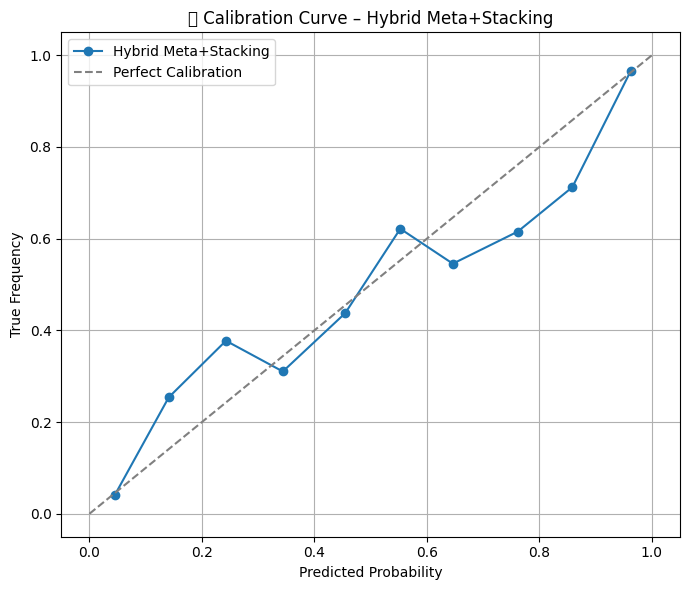

📉 Brier Score: 0.0506
✅ McNemar and CI results saved.

📊 F1 Confidence Intervals vs Hybrid:
           Lower   Upper  Mean Diff
Meta      0.0001  0.0045     0.0023
Stacking -0.0008  0.0036     0.0014
Weighted  0.0004  0.0066     0.0035

🧪 McNemar Test:
          Statistic  P-value
Meta         2.5312   0.1116
Stacking     0.9615   0.3268
Weighted     4.0000   0.0455


In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import f1_score, roc_auc_score, brier_score_loss, confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.utils import resample
import seaborn as sns

# -------------------------------
# 📂 Paths
# -------------------------------
BASE = "models/ensemble"
PLOT_DIR = f"{BASE}/plots"
RESULT_DIR = f"{BASE}/results"
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load hybrid predictions
# -------------------------------
df = pd.read_csv(f"{RESULT_DIR}/hybrid_meta_stacking_predictions.csv")
y_true = df["true"]
y_pred = df["hybrid_pred"]
y_prob = df["hybrid_prob"]

# -------------------------------
# 🔁 Merge other ensemble predictions
# -------------------------------
stacking_df = pd.read_csv(f"{RESULT_DIR}/stacking_predictions.csv")
weighted_df = pd.read_csv(f"{RESULT_DIR}/weighted_voting_predictions.csv")
meta_df     = pd.read_csv(f"{RESULT_DIR}/meta_ensemble_predictions.csv")

df["stacking_pred"] = stacking_df["stacking_pred"]
df["stacking_prob"] = stacking_df["stacking_prob"]
df["weighted_pred"] = weighted_df["weighted_pred"]
df["weighted_prob"] = weighted_df["weighted_prob"]
df["meta_pred"]     = meta_df["meta_pred"]
df["meta_prob"]     = meta_df["meta_prob"]

# -------------------------------
# 📈 1. Calibration Curve
# -------------------------------
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="uniform")

plt.figure(figsize=(7, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Hybrid Meta+Stacking")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("True Frequency")
plt.title("📏 Calibration Curve – Hybrid Meta+Stacking")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig(f"{PLOT_DIR}/hybrid_calibration_curve.png", dpi=300)
plt.close()

# -------------------------------
# 📉 2. Brier Score
# -------------------------------
brier = brier_score_loss(y_true, y_prob)
print(f"📉 Brier Score: {brier:.4f}")

# -------------------------------
# 🧪 3. McNemar Test
# -------------------------------
comparison_models = {
    "Meta": "meta_pred",
    "Stacking": "stacking_pred",
    "Weighted": "weighted_pred"
}
mcnemar_results = {}

for name, col in comparison_models.items():
    y_compare = df[col]
    both = pd.DataFrame({"hybrid": y_pred, "baseline": y_compare, "true": y_true})
    disagree = both[(both["hybrid"] != both["true"]) | (both["baseline"] != both["true"])]

    table = confusion_matrix(disagree["hybrid"] == disagree["true"],
                             disagree["baseline"] == disagree["true"])
    
    result = mcnemar(table, exact=False)
    mcnemar_results[name] = {
        "Statistic": round(result.statistic, 4),
        "P-value": round(result.pvalue, 4)
    }

# -------------------------------
# 📊 4. F1 Confidence Interval (Bootstrapping)
# -------------------------------
def bootstrap_ci(y_true, pred1, pred2, n=1000):
    diffs = []
    for _ in range(n):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        f1_1 = f1_score(y_true[idx], pred1[idx])
        f1_2 = f1_score(y_true[idx], pred2[idx])
        diffs.append(f1_1 - f1_2)
    return np.percentile(diffs, [2.5, 97.5]), np.mean(diffs)

ci_results = {}
for name, col in comparison_models.items():
    ci_range, diff = bootstrap_ci(y_true.values, y_pred.values, df[col].values)
    ci_results[name] = {
        "Lower": round(ci_range[0], 4),
        "Upper": round(ci_range[1], 4),
        "Mean Diff": round(diff, 4)
    }

# -------------------------------
# 💾 Save Results
# -------------------------------
pd.DataFrame(mcnemar_results).T.to_csv(f"{RESULT_DIR}/hybrid_vs_mcnemar.csv")
pd.DataFrame(ci_results).T.to_csv(f"{RESULT_DIR}/hybrid_vs_f1_ci.csv")
print("✅ McNemar and CI results saved.")

# 🖨️ Print for reference
print("\n📊 F1 Confidence Intervals vs Hybrid:")
print(pd.DataFrame(ci_results).T)

print("\n🧪 McNemar Test:")
print(pd.DataFrame(mcnemar_results).T)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/3578395163.py:44: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_meta, X_meta[:100], show=False, plot_type="bar")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explici

<Figure size 640x480 with 0 Axes>

/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


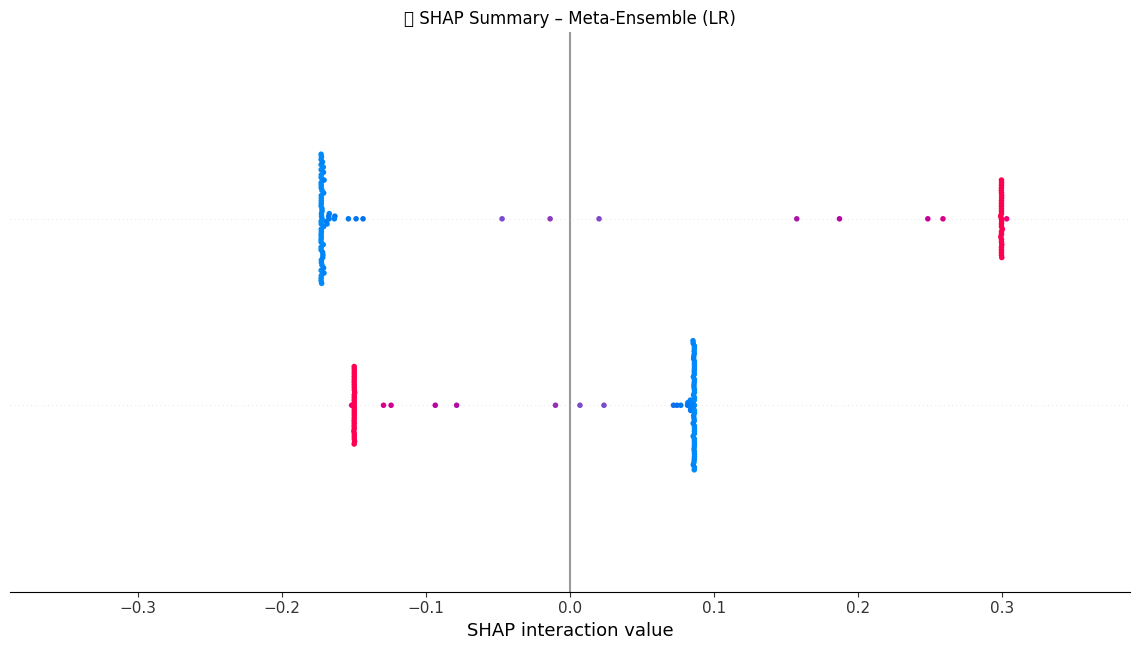

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/3578395163.py:51: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_hybrid, X_hybrid[:100], show=False, plot_type="bar")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` exp

<Figure size 640x480 with 0 Axes>

/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


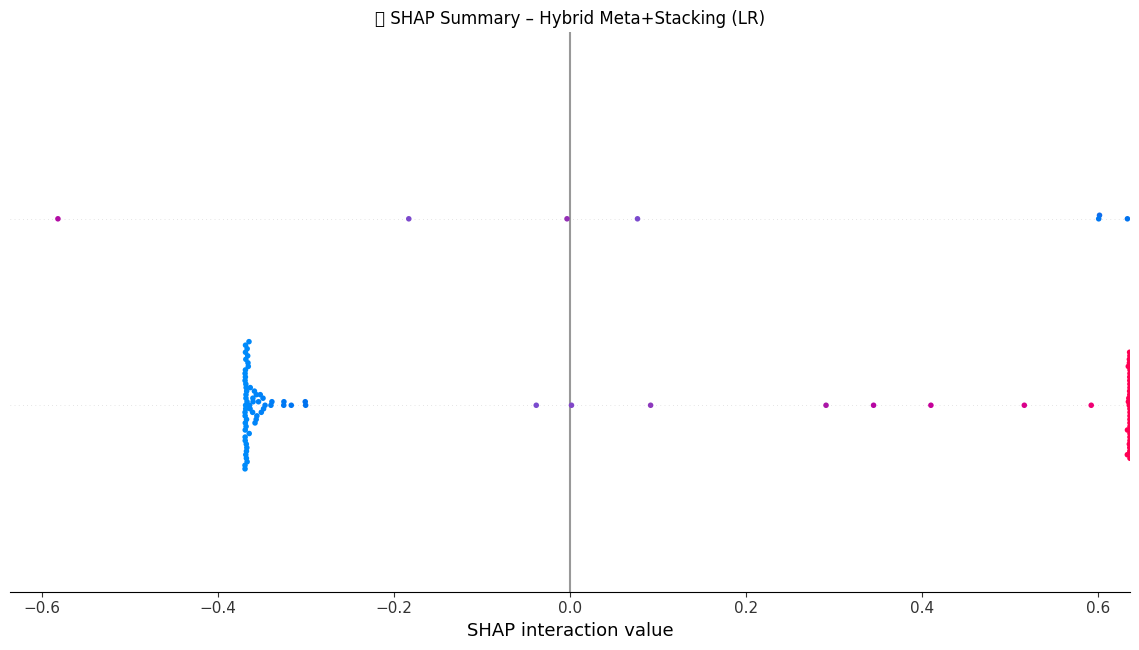

✅ SHAP summary plots saved to: models/ensemble/plots


In [32]:
import os
import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# -------------------------------
# 📂 Paths
# -------------------------------
BASE_DIR = "models/ensemble"
RESULT_DIR = os.path.join(BASE_DIR, "results")
PLOT_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Meta Model & Predictions
# -------------------------------
meta_model = joblib.load(f"{BASE_DIR}/results/meta_model_lr.pkl")
df_meta = pd.read_csv(os.path.join(RESULT_DIR, "meta_ensemble_predictions.csv"))
X_meta = df_meta[["voting_soft_prob", "weighted_prob", "stacking_prob"]]

# -------------------------------
# 🧠 Refit Hybrid Model from CSV
# -------------------------------
df_hybrid = pd.read_csv(os.path.join(RESULT_DIR, "hybrid_meta_stacking_predictions.csv"))
X_hybrid = df_hybrid[["voting_soft_prob", "weighted_prob", "stacking_prob"]]
y_hybrid = df_hybrid["true"]
hybrid_model = LogisticRegression(C=10.0, solver="liblinear", max_iter=1000)
hybrid_model.fit(X_hybrid, y_hybrid)

# -------------------------------
# 🧠 SHAP (CPU-safe with KernelExplainer)
# -------------------------------
explainer_meta = shap.KernelExplainer(meta_model.predict_proba, X_meta[:100])
explainer_hybrid = shap.KernelExplainer(hybrid_model.predict_proba, X_hybrid[:100])

shap_vals_meta = explainer_meta.shap_values(X_meta[:100])
shap_vals_hybrid = explainer_hybrid.shap_values(X_hybrid[:100])

# -------------------------------
# 📊 Save Summary Bar Plots
# -------------------------------
shap.summary_plot(shap_vals_meta, X_meta[:100], show=False, plot_type="bar")
plt.title("📊 SHAP Summary – Meta-Ensemble (LR)")
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(PLOT_DIR, "shap_meta_lr_bar.png"), dpi=300)
plt.close()

shap.summary_plot(shap_vals_hybrid, X_hybrid[:100], show=False, plot_type="bar")
plt.title("📊 SHAP Summary – Hybrid Meta+Stacking (LR)")
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(PLOT_DIR, "shap_hybrid_lr_bar.png"), dpi=300)
plt.close()

print("✅ SHAP summary plots saved to:", PLOT_DIR)

🔄 Processing: Hybrid
🔄 Processing: Meta
🔄 Processing: Weighted


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/1852322819.py:80: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/1852322819.py:81: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(PLOT_DIR, "learning_curve_3ensemble_smoothed.png"), dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


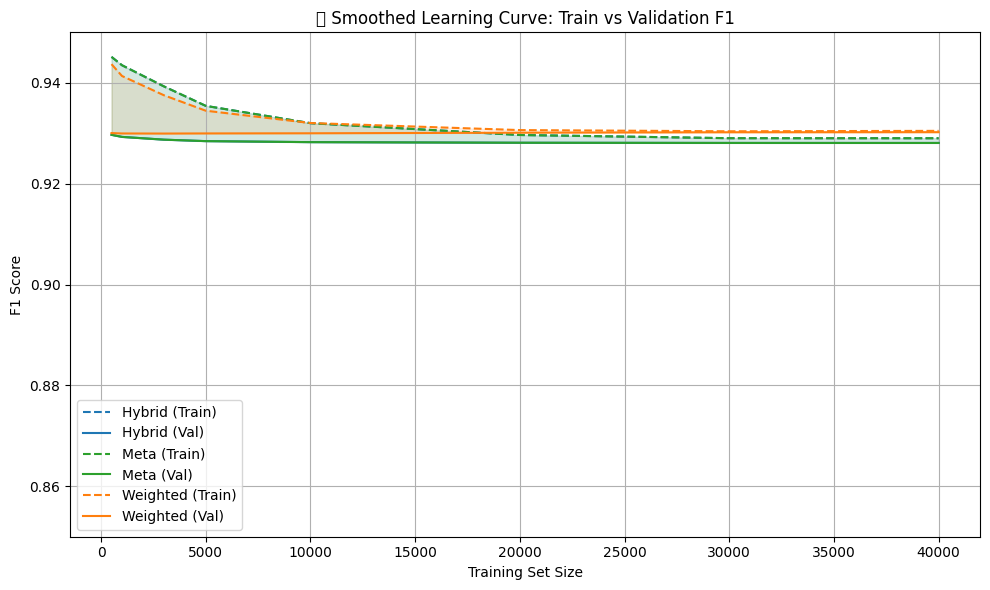

✅ Saved: learning_curve_3ensemble_smoothed.png


In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import f1_score
from scipy.ndimage import gaussian_filter1d

# -------------------------------
# 📂 Paths
# -------------------------------
BASE_DIR = "models/ensemble"
DATA_DIR = os.path.join(BASE_DIR, "results")
PLOT_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 🔁 Setup
# -------------------------------
model_files = {
    "Hybrid": "hybrid_meta_stacking_predictions.csv",
    "Meta": "meta_ensemble_predictions.csv",
    "Weighted": "weighted_voting_predictions.csv",
}
model_features = {
    "Hybrid": ["voting_soft_prob", "weighted_prob", "stacking_prob"],
    "Meta": ["voting_soft_prob", "weighted_prob", "stacking_prob"],
    "Weighted": ["svm2_prob", "rf_prob", "nb2_prob", "nb1_prob"]
}
colors = {"Hybrid": "#1f77b4", "Meta": "#2ca02c", "Weighted": "#ff7f0e"}
train_sizes = [500, 1000, 3000, 5000, 10000, 20000, 30000, 40000]

# -------------------------------
# 📈 Learning Curves
# -------------------------------
plt.figure(figsize=(10, 6))

for name, file in model_files.items():
    print(f"🔄 Processing: {name}")
    df = pd.read_csv(os.path.join(DATA_DIR, file)).dropna()
    X_all = df[model_features[name]].values
    y_all = df["true"].values

    # Use full data as validation for fair comparison
    X_val = X_all
    y_val = y_all

    f1_train_list, f1_val_list = [], []

    for size in train_sizes:
        X_sub, y_sub = resample(X_all, y_all, n_samples=size, random_state=42)
        model = LogisticRegression(C=10.0, solver="liblinear", max_iter=1000)
        model.fit(X_sub, y_sub)

        y_pred_train = model.predict(X_sub)
        y_pred_val = model.predict(X_val)

        f1_train_list.append(f1_score(y_sub, y_pred_train))
        f1_val_list.append(f1_score(y_val, y_pred_val))

    # Smooth
    f1_train_smooth = gaussian_filter1d(f1_train_list, sigma=1)
    f1_val_smooth = gaussian_filter1d(f1_val_list, sigma=1)

    # Plot
    plt.plot(train_sizes, f1_train_smooth, linestyle="--", label=f"{name} (Train)", color=colors[name])
    plt.plot(train_sizes, f1_val_smooth, linestyle="-", label=f"{name} (Val)", color=colors[name])
    plt.fill_between(train_sizes, f1_train_smooth, f1_val_smooth, alpha=0.1, color=colors[name])

# -------------------------------
# 🎯 Final Plot
# -------------------------------
plt.title("📈 Smoothed Learning Curve: Train vs Validation F1")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.ylim(0.85, 0.95)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "learning_curve_3ensemble_smoothed.png"), dpi=300)
plt.show()
print("✅ Saved: learning_curve_3ensemble_smoothed.png")

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/1659540437.py:56: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_4348/1659540437.py:57: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(PLOT_PATH, dpi=300)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


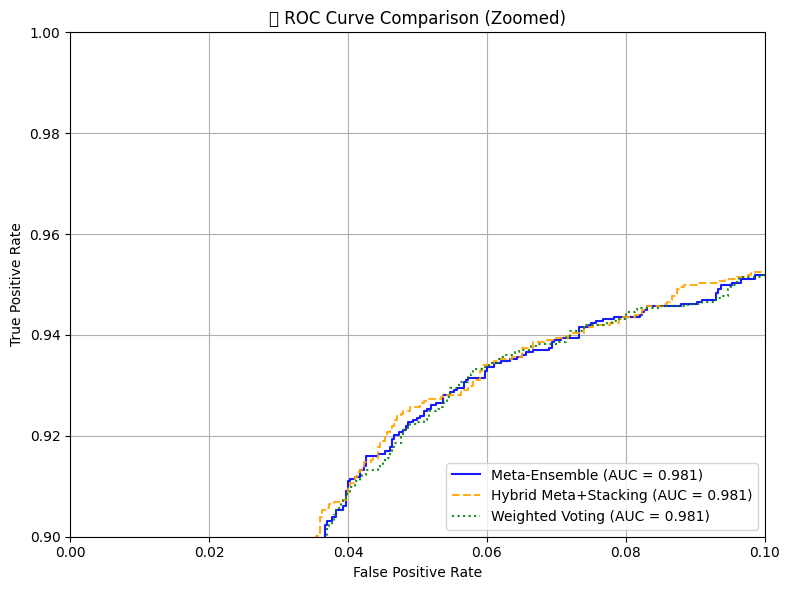

✅ Zoomed ROC curve saved: models/ensemble/plots/roc_curve_comparison_distinct.png


In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -------------------------------
# 📂 Paths
# -------------------------------
BASE_DIR = "models/ensemble/results"
PLOT_PATH = "models/ensemble/plots/roc_curve_comparison_distinct.png"
os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)

# -------------------------------
# 📄 Load Predictions
# -------------------------------
df_meta = pd.read_csv(os.path.join(BASE_DIR, "meta_ensemble_predictions.csv"))
df_hybrid = pd.read_csv(os.path.join(BASE_DIR, "hybrid_meta_stacking_predictions.csv"))
df_weighted = pd.read_csv(os.path.join(BASE_DIR, "weighted_voting_predictions.csv"))

# -------------------------------
# 📊 Compute ROC curves
# -------------------------------
fpr_meta, tpr_meta, _ = roc_curve(df_meta["true"], df_meta["meta_prob"])
auc_meta = auc(fpr_meta, tpr_meta)

fpr_hybrid, tpr_hybrid, _ = roc_curve(df_hybrid["true"], df_hybrid["hybrid_prob"])
auc_hybrid = auc(fpr_hybrid, tpr_hybrid)

fpr_weighted, tpr_weighted, _ = roc_curve(df_weighted["true"], df_weighted["weighted_prob"])
auc_weighted = auc(fpr_weighted, tpr_weighted)

# -------------------------------
# 📈 Plot with styles & zoom
# -------------------------------
plt.figure(figsize=(8, 6))

plt.plot(fpr_meta, tpr_meta, linestyle="-", color="blue", label=f"Meta-Ensemble (AUC = {auc_meta:.3f})", alpha=0.9)
plt.plot(fpr_hybrid, tpr_hybrid, linestyle="--", color="orange", label=f"Hybrid Meta+Stacking (AUC = {auc_hybrid:.3f})", alpha=0.9)
plt.plot(fpr_weighted, tpr_weighted, linestyle=":", color="green", label=f"Weighted Voting (AUC = {auc_weighted:.3f})", alpha=0.9)

# Reference diagonal
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.5)

# Zoom in to highlight differences
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])

# -------------------------------
# 🖼️ Final Styling
# -------------------------------
plt.title("🔍 ROC Curve Comparison (Zoomed)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=300)
plt.show()

print(f"✅ Zoomed ROC curve saved: {PLOT_PATH}")